In [2]:
import numpy as np
import scipy
from scipy.special import expit


class BaseSmoothOracle(object):
    """
    Base class for implementation of oracles.
    """
    def func(self, x):
        """
        Computes the value of function at point x.
        """
        raise NotImplementedError('Func oracle is not implemented.')

    def grad(self, x):
        """
        Computes the gradient at point x.
        """
        raise NotImplementedError('Grad oracle is not implemented.')

    def hess(self, x):
        """
        Computes the Hessian matrix at point x.
        """
        raise NotImplementedError('Hessian oracle is not implemented.')

    def func_directional(self, x, d, alpha):
        """
        Computes phi(alpha) = f(x + alpha*d).
        """
        return np.squeeze(self.func(x + alpha * d))

    def grad_directional(self, x, d, alpha):
        """
        Computes phi'(alpha) = (f(x + alpha*d))'_{alpha}
        """
        return np.squeeze(self.grad(x + alpha * d).dot(d))


class QuadraticOracle(BaseSmoothOracle):
    """
    Oracle for quadratic function:
       func(x) = 1/2 x^TAx - b^Tx.
    """

    def __init__(self, A, b):
        if not scipy.sparse.isspmatrix_dia(A) and not np.allclose(A, A.T):
            raise ValueError('A should be a symmetric matrix.')
        self.A = A
        self.b = b

    def func(self, x):
        return 0.5 * np.dot(self.A.dot(x), x) - self.b.dot(x)

    def grad(self, x):
        return self.A.dot(x) - self.b

    def hess(self, x):
        return self.A


class LogRegL2Oracle(BaseSmoothOracle):
    """
    Oracle for logistic regression with l2 regularization:
         func(x) = 1/m sum_i log(1 + exp(-b_i * a_i^T x)) + regcoef / 2 ||x||_2^2.

    Let A and b be parameters of the logistic regression (feature matrix
    and labels vector respectively).
    For user-friendly interface use create_log_reg_oracle()

    Parameters
    ----------
        matvec_Ax : function
            Computes matrix-vector product Ax, where x is a vector of size n.
        matvec_ATx : function of x
            Computes matrix-vector product A^Tx, where x is a vector of size m.
        matmat_ATsA : function
            Computes matrix-matrix-matrix product A^T * Diag(s) * A,
    """
    def __init__(self, matvec_Ax, matvec_ATx, matmat_ATsA, b, regcoef):
        self.matvec_Ax = matvec_Ax
        self.matvec_ATx = matvec_ATx
        self.matmat_ATsA = matmat_ATsA
        self.b = b
        self.regcoef = regcoef

    def func(self, x):
        m = len(self.b)
        podexp = -self.b * self.matvec_Ax(x)
        return np.logaddexp(0, podexp) @ np.ones(m) / m + self.regcoef / 2 * np.linalg.norm(x) ** 2

    def grad(self, x):
        # TODO: Implement
        m = len(self.b)
        podexp = scipy.special.expit(-self.b * self.matvec_Ax(x))
        return -1 / m * self.matvec_ATx(self.b * podexp) + self.regcoef * x

    def hess(self, x):
        # TODO: Implement
        m = len(self.b)
        n = len(x)
        podexp = scipy.special.expit(-self.b * self.matvec_Ax(x))
        return 1 / m * self.matmat_ATsA(podexp * (1.0 - podexp)) + self.regcoef * np.eye(n)

class LogRegL2OptimizedOracle(LogRegL2Oracle):
    """
    Oracle for logistic regression with l2 regularization
    with optimized *_directional methods (are used in line_search).

    For explanation see LogRegL2Oracle.
    """
    def __init__(self, matvec_Ax, matvec_ATx, matmat_ATsA, b, regcoef):
        super().__init__(matvec_Ax, matvec_ATx, matmat_ATsA, b, regcoef)

    def func_directional(self, x, d, alpha):
        # TODO: Implement optimized version with pre-computation of Ax and Ad
        return None

    def grad_directional(self, x, d, alpha):
        # TODO: Implement optimized version with pre-computation of Ax and Ad
        return None


def create_log_reg_oracle(A, b, regcoef, oracle_type='usual'):
    """
    Auxiliary function for creating logistic regression oracles.
        `oracle_type` must be either 'usual' or 'optimized'
    """
    matvec_Ax = lambda x: A @ x
    matvec_ATx = lambda x: A.T @ x

    def matmat_ATsA(s):
        # TODO: Implement
        return A.T @ scipy.sparse.diags(s) @ A

    if oracle_type == 'usual':
        oracle = LogRegL2Oracle
    elif oracle_type == 'optimized':
        oracle = LogRegL2OptimizedOracle
    else:
        raise 'Unknown oracle_type=%s' % oracle_type
    return oracle(matvec_Ax, matvec_ATx, matmat_ATsA, b, regcoef)



def grad_finite_diff(func, x, eps=1e-8):
    """
    Returns approximation of the gradient using finite differences:
        result_i := (f(x + eps * e_i) - f(x)) / eps,
        where e_i are coordinate vectors:
        e_i = (0, 0, ..., 0, 1, 0, ..., 0)
                          >> i <<
    """
    # TODO: Implement numerical estimation of the gradient
    d = len(x)
    result = np.zeros(d)
    e = np.eye(d)
    for i in range(d):
        result[i] = (func(x + eps * e[i]) - func(x)) / eps
    return result


def hess_finite_diff(func, x, eps=1e-5):
    """
    Returns approximation of the Hessian using finite differences:
        result_{ij} := (f(x + eps * e_i + eps * e_j)
                               - f(x + eps * e_i)
                               - f(x + eps * e_j)
                               + f(x)) / eps^2,
        where e_i are coordinate vectors:
        e_i = (0, 0, ..., 0, 1, 0, ..., 0)
                          >> i <<
    """
    # TODO: Implement numerical estimation of the Hessian
    d  = len(x)
    result = np.zeros((d, d))
    e = np.eye(d)
    for i in range(d):
        for j in range(d):
            result[i][j] = (func(x + eps * e[i] + eps * e[j]) - func(x + eps * e[i])
             - func(x + eps * e[j]) + func(x)) / eps ** 2
    return result


In [3]:
import numpy as np
from numpy.linalg import LinAlgError
import scipy
from time import time
from datetime import datetime
from scipy.linalg import cho_factor, cho_solve
from collections import defaultdict

from scipy.optimize.linesearch import scalar_search_wolfe2

class LineSearchTool(object):
    """
    Line search tool for adaptively tuning the step size of the algorithm.

    method : String containing 'Wolfe', 'Armijo' or 'Constant'
        Method of tuning step-size.
        Must be be one of the following strings:
            - 'Wolfe' -- enforce strong Wolfe conditions;
            - 'Armijo" -- adaptive Armijo rule;
            - 'Constant' -- constant step size.
    kwargs :
        Additional parameters of line_search method:

        If method == 'Wolfe':
            c1, c2 : Constants for strong Wolfe conditions
            alpha_0 : Starting point for the backtracking procedure
                to be used in Armijo method in case of failure of Wolfe method.
        If method == 'Armijo':
            c1 : Constant for Armijo rule
            alpha_0 : Starting point for the backtracking procedure.
        If method == 'Constant':
            c : The step size which is returned on every step.
    """
    def __init__(self, method='Wolfe', **kwargs):
        self._method = method
        if self._method == 'Wolfe':
            self.c1 = kwargs.get('c1', 1e-4)
            self.c2 = kwargs.get('c2', 0.9)
            self.alpha_0 = kwargs.get('alpha_0', 1.0)
        elif self._method == 'Armijo':
            self.c1 = kwargs.get('c1', 1e-4)
            self.alpha_0 = kwargs.get('alpha_0', 1.0)
        elif self._method == 'Constant':
            self.c = kwargs.get('c', 1.0)
        else:
            raise ValueError('Unknown method {}'.format(method))

    @classmethod
    def from_dict(cls, options):
        if type(options) != dict:
            raise TypeError('LineSearchTool initializer must be of type dict')
        return cls(**options)

    def to_dict(self):
        return self.__dict__

    def line_search(self, oracle, x_k, d_k, previous_alpha=None):
        """
        Finds the step size alpha for a given starting point x_k
        and for a given search direction d_k that satisfies necessary
        conditions for phi(alpha) = oracle.func(x_k + alpha * d_k).

        Parameters
        ----------
        oracle : BaseSmoothOracle-descendant object
            Oracle with .func_directional() and .grad_directional() methods implemented for computing
            function values and its directional derivatives.
        x_k : np.array
            Starting point
        d_k : np.array
            Search direction
        previous_alpha : float or None
            Starting point to use instead of self.alpha_0 to keep the progress from
             previous steps. If None, self.alpha_0, is used as a starting point.

        Returns
        -------
        alpha : float or None if failure
            Chosen step size
        """
        # TODO: Implement line search procedures for Armijo, Wolfe and Constant steps.
        phi = lambda alpha: oracle.func_directional(x_k, d_k, alpha)
        derphi = lambda alpha: oracle.grad_directional(x_k, d_k, alpha)
        phi0 = phi(0)
        derphi0 = derphi(0)
        if self._method == 'Constant':
            alpha = self.c
        elif self._method == 'Armijo':
            alpha = self.alpha_0 if previous_alpha is None else previous_alpha
            derphi0 = derphi(0)
            while phi(alpha) > phi(0) + self.c1 * alpha * derphi0:
                alpha = alpha / 2
        elif self._method == 'Wolfe':
            alpha = scalar_search_wolfe2(phi, derphi, phi0, None, derphi0, c1=self.c1, c2=self.c2)
            alpha = alpha[0]
            if alpha is None:
              alpha = self.alpha_0 if previous_alpha is None else previous_alpha
              derphi0 = np.dot(oracle.grad(x_k), d_k)
              while phi(alpha) > phi(0) + self.c1 * alpha * derphi0:
                  alpha = alpha / 2
        return alpha


def get_line_search_tool(line_search_options=None):
    if line_search_options:
        if type(line_search_options) is LineSearchTool:
            return line_search_options
        else:
            return LineSearchTool.from_dict(line_search_options)
    else:
        return LineSearchTool()


def gradient_descent(oracle, x_0, tolerance=1e-5, max_iter=10000,
                     line_search_options=None, trace=False, display=False):
    """
    Gradien descent optimization method.

    Parameters
    ----------
    oracle : BaseSmoothOracle-descendant object
        Oracle with .func(), .grad() and .hess() methods implemented for computing
        function value, its gradient and Hessian respectively.
    x_0 : np.array
        Starting point for optimization algorithm
    tolerance : float
        Epsilon value for stopping criterion.
    max_iter : int
        Maximum number of iterations.
    line_search_options : dict, LineSearchTool or None
        Dictionary with line search options. See LineSearchTool class for details.
    trace : bool
        If True, the progress information is appended into history dictionary during training.
        Otherwise None is returned instead of history.
    display : bool
        If True, debug information is displayed during optimization.
        Printing format and is up to a student and is not checked in any way.

    Returns
    -------
    x_star : np.array
        The point found by the optimization procedure
    message : string
        "success" or the description of error:
            - 'iterations_exceeded': if after max_iter iterations of the method x_k still doesn't satisfy
                the stopping criterion.
            - 'computational_error': in case of getting Infinity or None value during the computations.
    history : dictionary of lists or None
        Dictionary containing the progress information or None if trace=False.
        Dictionary has to be organized as follows:
            - history['time'] : list of floats, containing time in seconds passed from the start of the method
            - history['func'] : list of function values f(x_k) on every step of the algorithm
            - history['grad_norm'] : list of values Euclidian norms ||g(x_k)|| of the gradient on every step of the algorithm
            - history['x'] : list of np.arrays, containing the trajectory of the algorithm. ONLY STORE IF x.size <= 2

    Example:
    --------
    >> oracle = QuadraticOracle(np.eye(5), np.arange(5))
    >> x_opt, message, history = gradient_descent(oracle, np.zeros(5), line_search_options={'method': 'Armijo', 'c1': 1e-4})
    >> print('Found optimal point: {}'.format(x_opt))
       Found optimal point: [ 0.  1.  2.  3.  4.]
    """
    history = defaultdict(list) if trace else None
    line_search_tool = get_line_search_tool(line_search_options)
    x_k = np.copy(x_0)

    # TODO: Implement gradient descent
    # Use line_search_tool.line_search() for adaptive step size.
    if display:
        print('Optimization debug information')
    times_0 = time()
    grad_k = lambda t: oracle.grad(t)
    func_k = lambda t: oracle.func(t)
    times_k = time() - times_0
    grad_0 = grad_k(x_0)
    if trace:
      history['time'] = [times_k]
      history['func'] = [func_k(x_k)]
      history['grad_norm'] = [np.linalg.norm(grad_0)]
      if x_k.size <= 2:
        history['x'] = [x_k]

    try:
        alpha = line_search_tool.alpha_0
    except:
        alpha = 1.0
    flag = False
    for _ in range(max_iter):
        grad = grad_k(x_k)
        if np.linalg.norm(grad) ** 2 <= tolerance * np.linalg.norm(grad_0) ** 2:
            return x_k, 'success', history

        if not (np.all(np.isfinite(x_k)) and np.all(np.isfinite(grad))):
            return x_k, 'computational_error', history

        alpha = line_search_tool.line_search(oracle=oracle, x_k=x_k, d_k=-grad, previous_alpha=alpha)
        x_k = x_k - alpha * grad
        times = time() - times_0
        if trace:
          history['time'].append(times)
          history['func'].append(func_k(x_k))
          history['grad_norm'].append(np.linalg.norm(-grad_k(x_k)))
          if x_k.size <= 2:
              history['x'].append(x_k)

        if np.linalg.norm(grad_k(x_k)) ** 2 <= tolerance * np.linalg.norm(grad_0) ** 2:
            flag = True

    if flag:
      return x_k, 'success', history
    else:
      return x_k, 'iterations_exceeded', history


def newton(oracle, x_0, tolerance=1e-5, max_iter=100, line_search_options=None, trace=False, display=False):
    """
    Newton's optimization method.

    Parameters
    ----------
    oracle : BaseSmoothOracle-descendant object
        Oracle with .func(), .grad() and .hess() methods implemented for computing
        function value, its gradient and Hessian respectively. If the Hessian
        returned by the oracle is not positive-definite method stops with message="newton_direction_error"
    x_0 : np.array
        Starting point for optimization algorithm
    tolerance : float
        Epsilon value for stopping criterion.
    max_iter : int
        Maximum number of iterations.
    line_search_options : dict, LineSearchTool or None
        Dictionary with line search options. See LineSearchTool class for details.
    trace : bool
        If True, the progress information is appended into history dictionary during training.
        Otherwise None is returned instead of history.
    display : bool
        If True, debug information is displayed during optimization.

    Returns
    -------
    x_star : np.array
        The point found by the optimization procedure
    message : string
        'success' or the description of error:
            - 'iterations_exceeded': if after max_iter iterations of the method x_k still doesn't satisfy
                the stopping criterion.
            - 'newton_direction_error': in case of failure of solving linear system with Hessian matrix (e.g. non-invertible matrix).
            - 'computational_error': in case of getting Infinity or None value during the computations.
    history : dictionary of lists or None
        Dictionary containing the progress information or None if trace=False.
        Dictionary has to be organized as follows:
            - history['time'] : list of floats, containing time passed from the start of the method
            - history['func'] : list of function values f(x_k) on every step of the algorithm
            - history['grad_norm'] : list of values Euclidian norms ||g(x_k)|| of the gradient on every step of the algorithm
            - history['x'] : list of np.arrays, containing the trajectory of the algorithm. ONLY STORE IF x.size <= 2

    Example:
    --------
    >> oracle = QuadraticOracle(np.eye(5), np.arange(5))
    >> x_opt, message, history = newton(oracle, np.zeros(5), line_search_options={'method': 'Constant', 'c': 1.0})
    >> print('Found optimal point: {}'.format(x_opt))
       Found optimal point: [ 0.  1.  2.  3.  4.]
    """
    history = defaultdict(list) if trace else None
    line_search_tool = get_line_search_tool(line_search_options)
    x_k = np.copy(x_0)

    if display:
        print('Optimization debug information')
    times_0 = time()

    grad_k = lambda t: oracle.grad(t)
    func_k = lambda t: oracle.func(t)
    grad_0 = grad_k(x_0)
    times_k = time() - times_0
    if trace:
      history['time'] = [times_k]
      history['func'] = [func_k(x_k)]
      history['grad_norm'] = [np.linalg.norm(grad_0)]
      if x_k.size <= 2:
        history['x'] = [x_k]

    alpha0 = 1
    for _ in range(max_iter):
        if np.linalg.norm(grad_k(x_k)) ** 2 <= tolerance * np.linalg.norm(grad_0) ** 2:
            return x_k, 'success', history
        try:
            grad = grad_k(x_k)
            hess = oracle.hess(x_k)
            d_k = cho_solve((cho_factor(hess)), -grad)
        except LinAlgError:
            return x_k, 'newton_direction_error', history

        if not (np.all(np.isfinite(x_k)) and np.all(np.isfinite(d_k))):
            return x_k, 'computational_error', history

        alpha = line_search_tool.line_search(oracle=oracle, x_k=x_k, d_k=d_k, previous_alpha=alpha0)
        x_k = x_k + alpha * d_k
        times = time() - times_0
        if trace:
          history['time'].append(times)
          history['func'].append(func_k(x_k))
          history['grad_norm'].append(np.linalg.norm(grad_k(x_k)))
          if x_k.size <= 2:
              history['x'].append(x_k)

        if np.linalg.norm(grad_k(x_k)) ** 2 <= tolerance * np.linalg.norm(grad_0) ** 2:
            return x_k, 'success', history

    return x_k, 'iterations_exceeded', history


C:\Users\Алим\AppData\Local\Temp\ipykernel_20372\3981353828.py:9: DeprecationWarning: Please use `scalar_search_wolfe2` from the `scipy.optimize` namespace, the `scipy.optimize.linesearch` namespace is deprecated.
  from scipy.optimize.linesearch import scalar_search_wolfe2


In [4]:
A = np.array([[1, 2, 3], [2, 4, 7], [3, 7, 8]])
b = np.array([10, 14, 18])
x = np.array([1, 2, 3])
f = QuadraticOracle(A, b)
g = f.grad(x)
gf = grad_finite_diff(f.func, x)
print(f"{np.linalg.norm(g - gf)}")

1.832125088911075e-06


In [5]:
A = np.array([[1, 2, 3], [2, 4, 7], [3, 7, 8]])
b = np.array([10, 14, 18])
x = np.array([1, 2, 3])
f = QuadraticOracle(A, b)
h = f.hess(x)
hf = hess_finite_diff(f.func, x)
print(f"{np.linalg.norm(h - hf)}")

0.0006275049390415878


In [6]:
A = np.array([[1, 2, 3], [2, 4, 7], [3, 7, 8]])
b = np.array([10, 14, 18])
f = QuadraticOracle(A, b)
h = hess_finite_diff(f.func, np.array([5, 5, 5]))
print(f"A: \n{A}")
print(f"hess: \n{h}")

A: 
[[1 2 3]
 [2 4 7]
 [3 7 8]]
hess: 
[[0.9993073  2.00031991 2.99962721]
 [2.00031991 4.00063982 7.00083547]
 [2.99962721 7.00083547 8.00014277]]


In [5]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def plot_levels(func, xrange=None, yrange=None, levels=None):
    """
    Plotting the contour lines of the function.

    Example:
    --------
    >> oracle = oracles.QuadraticOracle(np.array([[1.0, 2.0], [2.0, 5.0]]), np.zeros(2))
    >> plot_levels(oracle.func)
    """
    if xrange is None:
        xrange = [-6, 6]
    if yrange is None:
        yrange = [-5, 5]
    if levels is None:
        levels = [0, 0.25, 1, 4, 9, 16, 25]

    x = np.linspace(xrange[0], xrange[1], 100)
    y = np.linspace(yrange[0], yrange[1], 100)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros(X.shape)
    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
            Z[i, j] = func(np.array([X[i, j], Y[i, j]]))

    CS = plt.contour(X, Y, Z, levels=levels, colors='k', linewidth=4.0)
    plt.clabel(CS, inline=1, fontsize=8)
    plt.grid()


def plot_trajectory(func, history, fit_axis=False, label=None, save=None, color=None):
    """
    Plotting the trajectory of a method.
    Use after plot_levels(...).

    Example:
    --------
    >> oracle = oracles.QuadraticOracle(np.array([[1.0, 2.0], [2.0, 5.0]]), np.zeros(2))
    >> [x_star, msg, history] = optimization.gradient_descent(oracle, np.array([3.0, 1.5], trace=True)
    >> plot_levels(oracle.func)
    >> plot_trajectory(oracle.func, history['x'])
    """
    x_values, y_values = zip(*history)
    plt.plot(x_values, y_values, '-v', linewidth=2.0, ms=5.0,
             alpha=1.0, c=color, label=label)

    # Tries to adapt axis-ranges for the trajectory:
    if fit_axis:
        xmax, ymax = np.max(x_values), np.max(y_values)
        COEF = 1.5
        xrange = [-xmax * COEF, xmax * COEF]
        yrange = [-ymax * COEF, ymax * COEF]
        plt.xlim(xrange)
        plt.ylim(yrange)
        plt.show()

In [166]:
def exp_1(A: np.ndarray):
    cond = np.linalg.cond(A)
    oracle  = QuadraticOracle(A, np.zeros(2))
    x_0 = np.random.uniform(-5, 5, size=2)
    for i, method in enumerate(['Wolfe', 'Armijo', 'Constant']):
        c = 'orange' if method == 'Wolfe' else ('g' if method == 'Armijo' else 'b')
        [x_star, msg, history] = gradient_descent(oracle, x_0, line_search_options={'method' : method, 'c': 0.5, 'alpha_0': 100},
                                                          trace=True)
        plt.figure()
        plot_levels(oracle.func)
        plot_trajectory(oracle.func, history['x'], label=f'num_iter = {len(history["x"]) - 1}', color=c)
        plt.title(f'Число обусловленности = {cond}, метод = {method}')
        plt.legend()
    plt.show()

In [186]:
def test_1():
  Mtx_small = np.array([
          [1, 0.3],
          [0.3, 2]
  ])
  Mtx_mean = np.array([
        [0.15, 0.15],
        [0.15, 1.5]
  ])
  Mtx_big = np.array([
        [0.1, 0.3],
        [0.3, 2]
  ])
  exp_1(Mtx_big)


<ipython-input-4-d9d8276376d9>:30: UserWarning: The following kwargs were not used by contour: 'linewidth'
  CS = plt.contour(X, Y, Z, levels=levels, colors='k', linewidth=4.0)


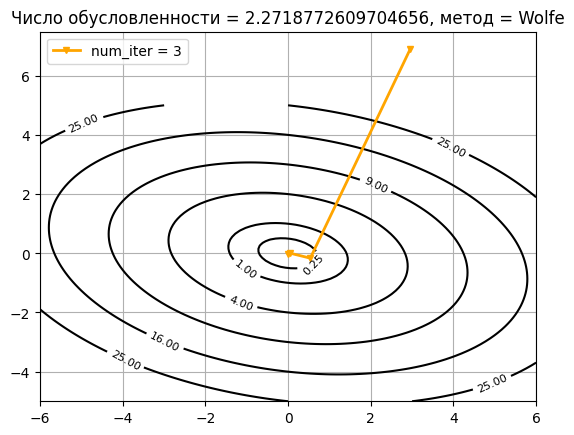

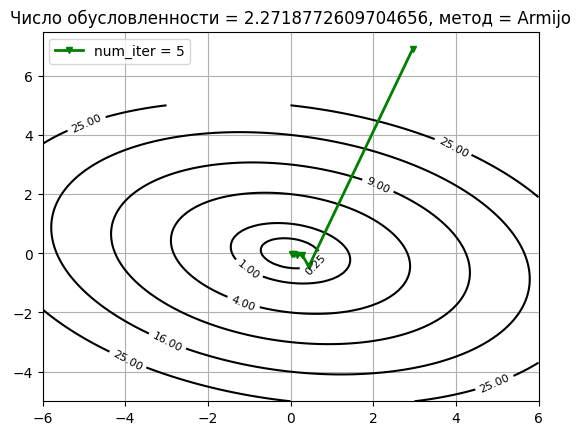

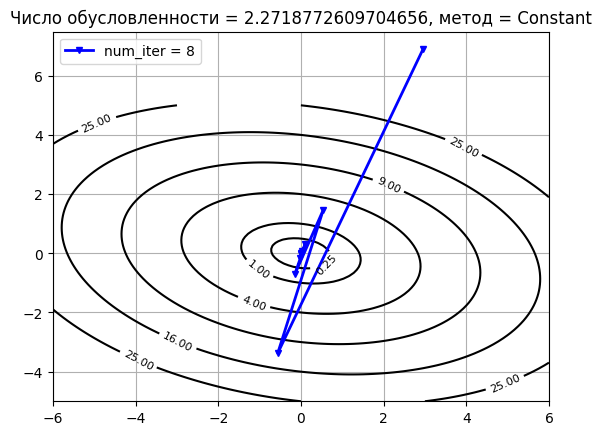

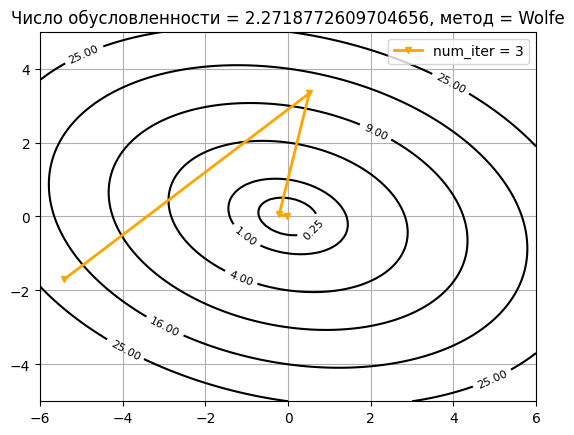

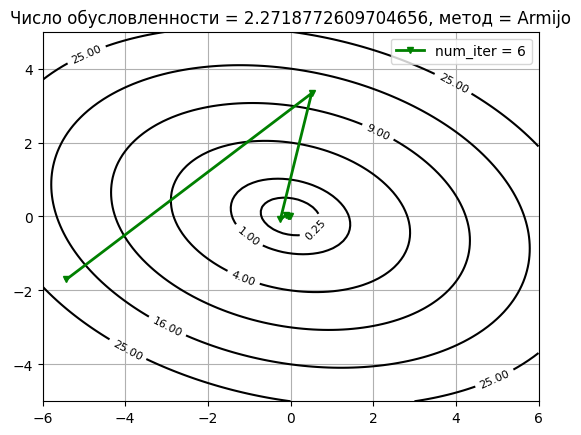

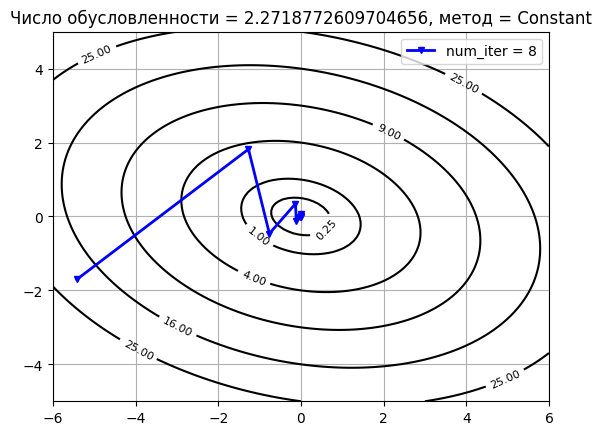

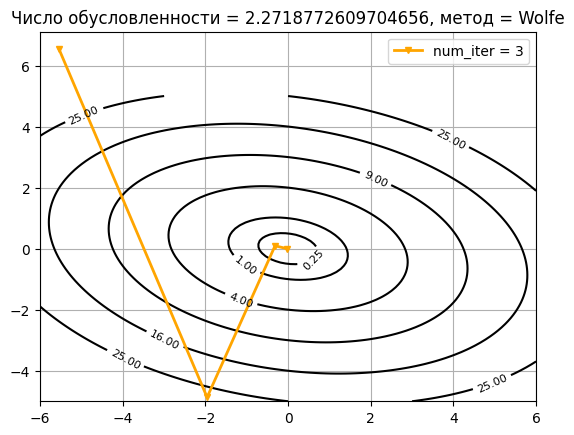

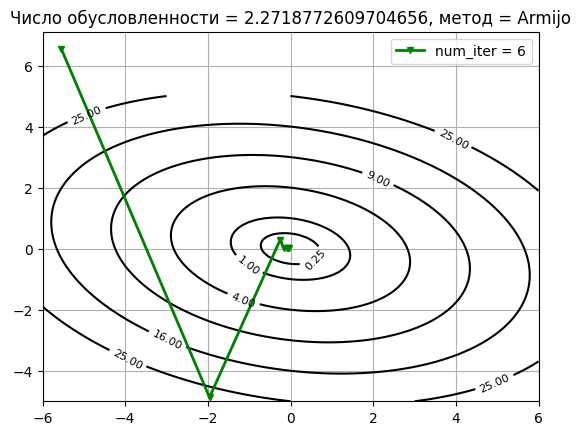

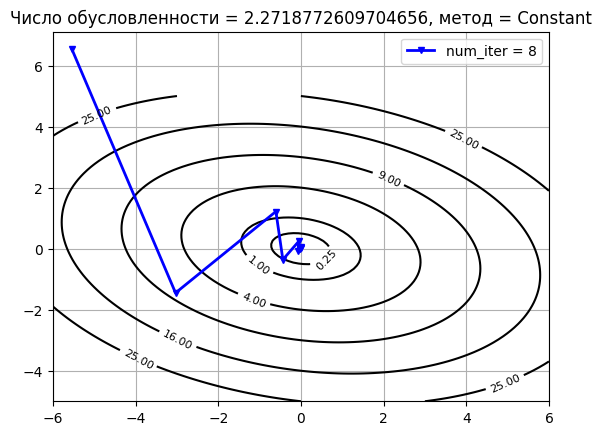

In [ ]:
test_1() # маленькое

<ipython-input-5-d9d8276376d9>:30: UserWarning: The following kwargs were not used by contour: 'linewidth'
  CS = plt.contour(X, Y, Z, levels=levels, colors='k', linewidth=4.0)


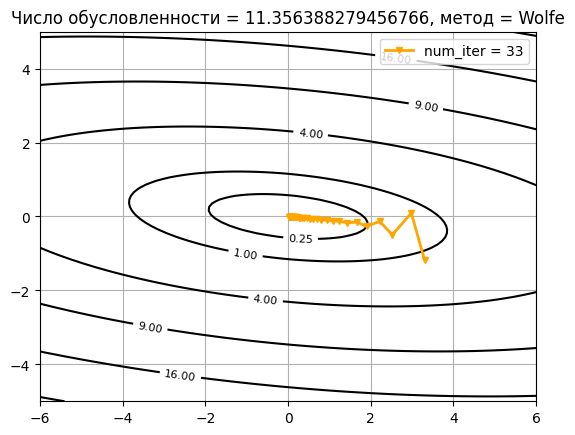

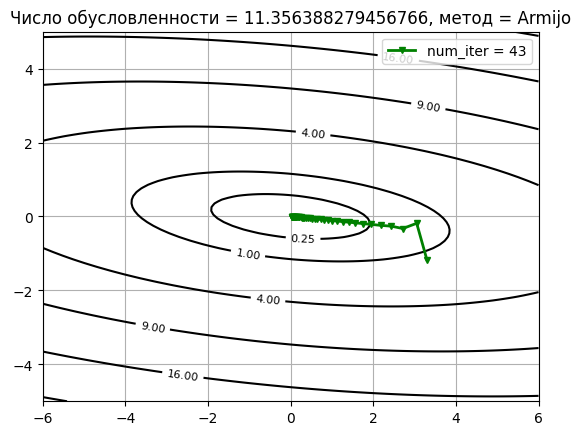

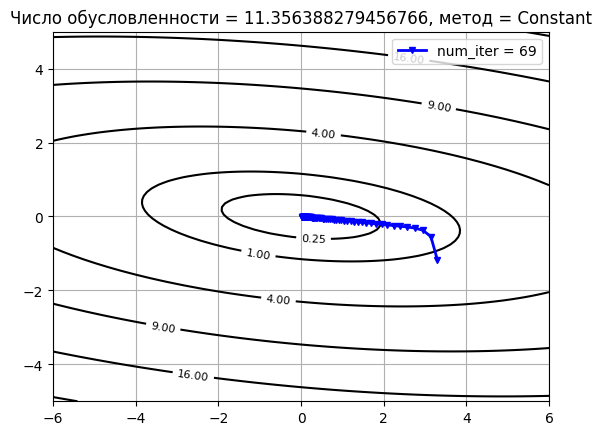

In [177]:
test_1() # среднее

<ipython-input-5-d9d8276376d9>:30: UserWarning: The following kwargs were not used by contour: 'linewidth'
  CS = plt.contour(X, Y, Z, levels=levels, colors='k', linewidth=4.0)


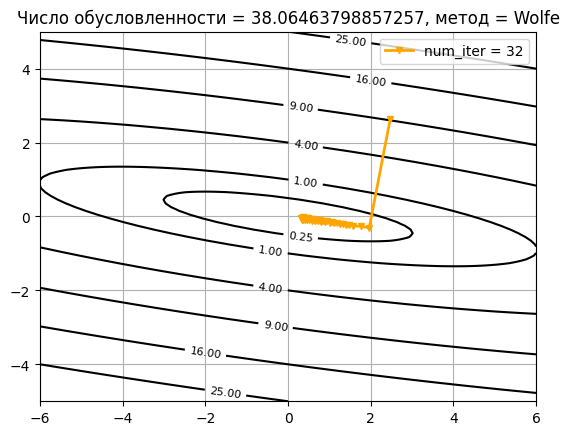

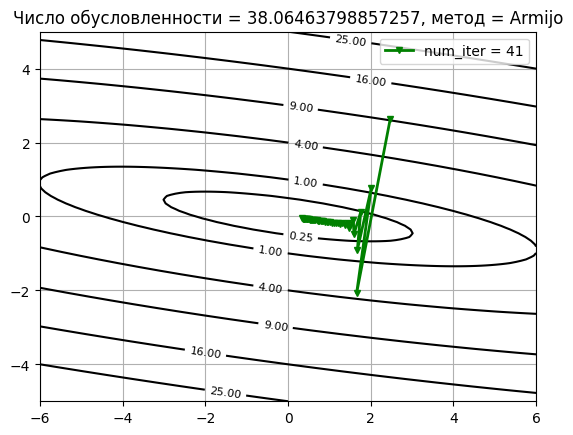

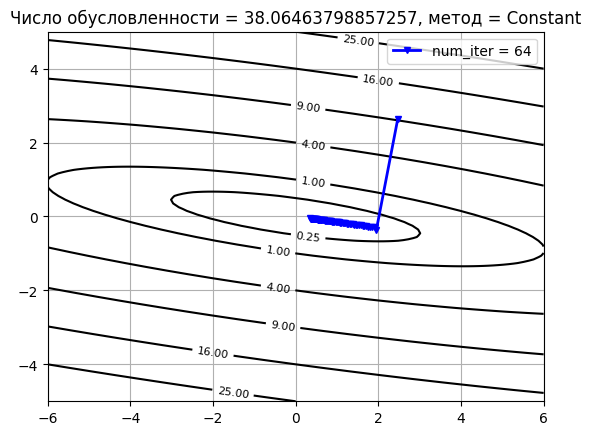

In [190]:
test_1() # Большое

In [104]:
def matrix(k: int, n: int):
    d = np.random.uniform(1, k, n)
    d[0], d[-1] = 1, k
    # print(diag)
    A = scipy.sparse.diags(d)
    b = np.random.uniform(1, k, n)
    return A, b

def exp2(n: list[int], colors: list[str], method: str):
    k = list(range(0, 1000, 100))
    k[0] = 10
    T = {}
    for i in n:
        T[i] = [[] for _ in range(10)]
        for j in range(10):
            for ki in k:
                A, b = matrix(ki, i)
                oracle = QuadraticOracle(A, b)
                [x_star, _, history] = gradient_descent(oracle, np.zeros(i), line_search_options={'method' : method, 'c': 0.001}, trace=True)
                T[i][j].append(len(history['grad_norm']))
            plt.plot(k, T[i][j], color=colors[i])
        plt.plot(k, np.mean(T[i], axis=0), color=colors[i], label=f'n = {i}')
    plt.legend()
    plt.title(f"{method}")
    plt.ylabel('iters')
    plt.xlabel(r'κ')
    plt.show()

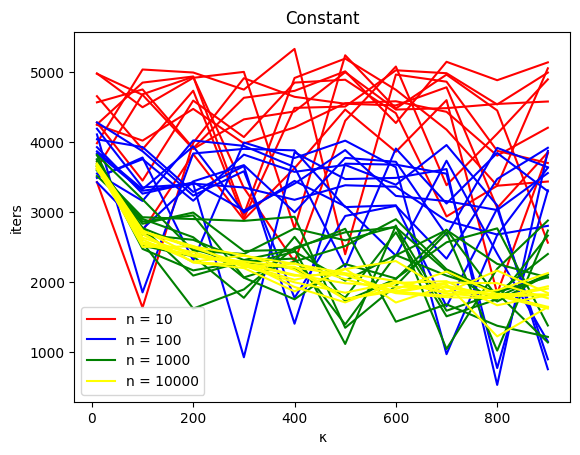

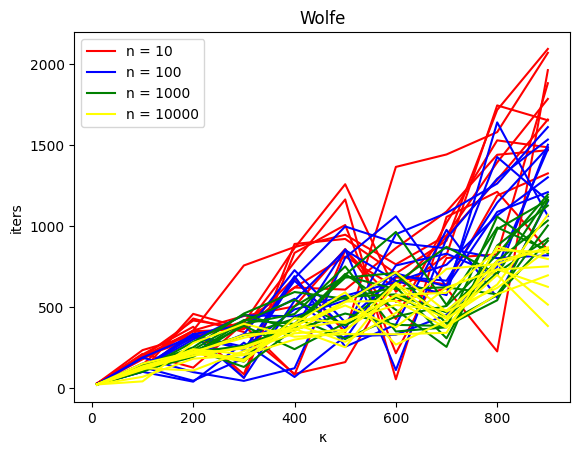

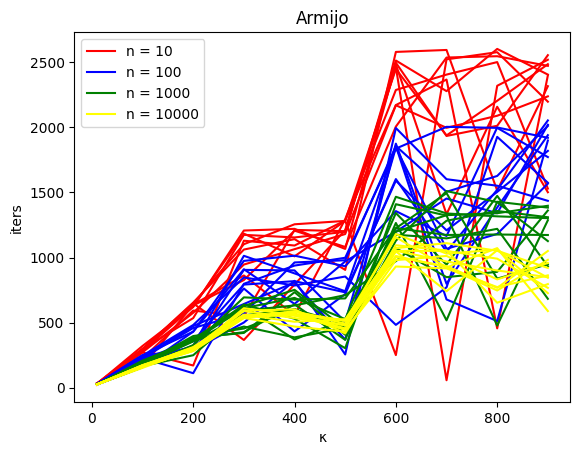

In [197]:
n = [10 ** i for i in range(1, 5)]
color = ['red', 'blue', 'green', 'yellow']
methods = ['Constant','Wolfe', 'Armijo']
for method in methods:
    exp2(n, color, method)

In [12]:
import os
import requests
from sklearn.datasets import load_svmlight_file
ds = {
    'w8a.txt': 'https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/w8a',
    'gisette.bz2': 'https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/gisette_scale.bz2',
    'real-sim.bz2': 'https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/real-sim.bz2'
}
  
for filename, url in ds.items():
    if not os.path.exists(filename):
        open(filename, 'wb').write(requests.get(url).content)

datasets = {}

for filename in ds.keys():
    datasets[filename] = load_svmlight_file(filename)

In [13]:
def time_of_func(grad, newt):
    plt.plot(grad['time'], np.abs((grad['func'][-1] - grad['func']) / grad['func'][0]))
    plt.plot(newt['time'], np.abs((newt['func'][-1] - newt['func']) / newt['func'][0]))
    plt.xlabel("Секунды", fontsize=15)
    plt.ylabel("Относительная ошибка", fontsize=15)
    plt.legend(["Gradient descent", "Newton"])
    plt.title('Зависимость значения функции от реального времени работы метода')
    plt.show()

def time_of_grad_norm(grad, newt):
    gd0 = grad['grad_norm'][0]
    nw0 = newt['grad_norm'][0]
    plt.semilogy(grad['time'], np.array(grad['grad_norm'])**2 / gd0**2)
    plt.semilogy(newt['time'], np.array(newt['grad_norm'])**2 / nw0**2)
    plt.xlabel("Секунды", fontsize=15)
    plt.ylabel(r'Относительная ошибка', fontsize=15)
    plt.legend(["Gradient descent", "Newton"])
    plt.title('Зависимость относительного квадрата нормы градиента')
    plt.show()

In [14]:
def exp_3(dataset):
    A, b = datasets[dataset]
    m = len(b)
    n = A.shape[1]
    oracle = create_log_reg_oracle(A, b, 1 / m)
    x0 = np.zeros(n)

    [_, _, history_grad] = gradient_descent(oracle, x0, trace=True)
    [_, _, history_newton] = newton(oracle, x0, trace=True)
    time_of_func(history_grad, history_newton)
    time_of_grad_norm(history_grad, history_newton)

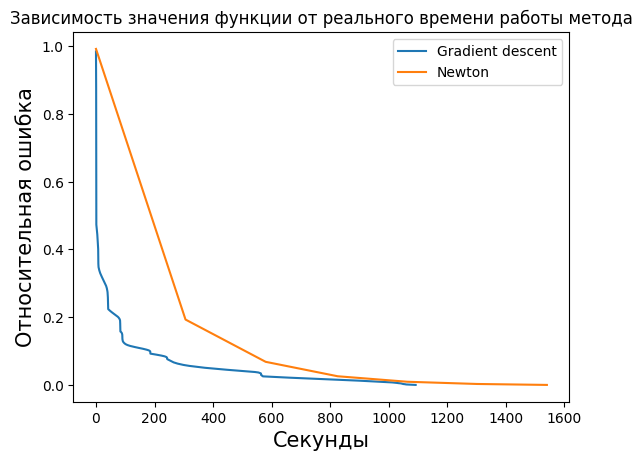

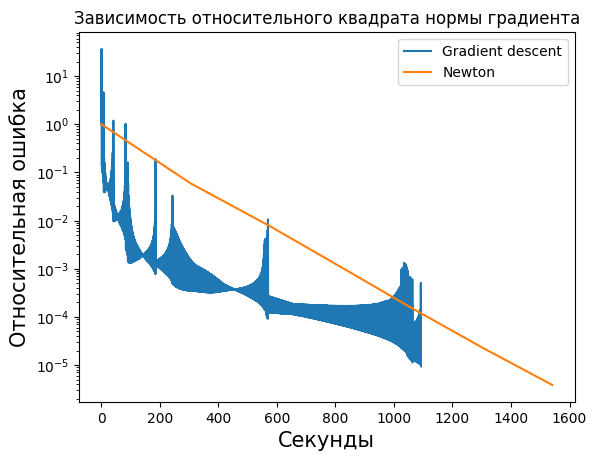

In [15]:
exp_3('gisette.bz2')

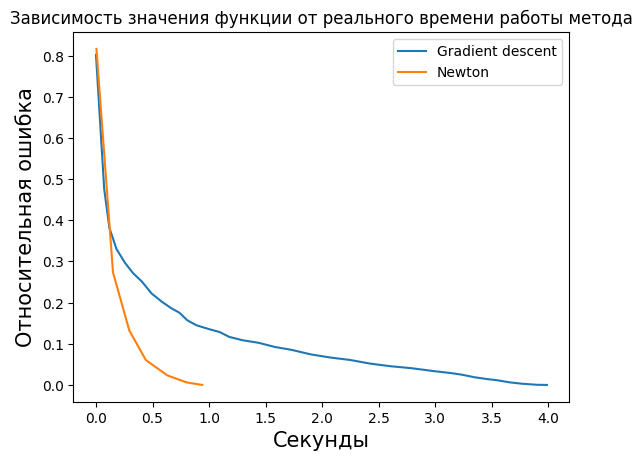

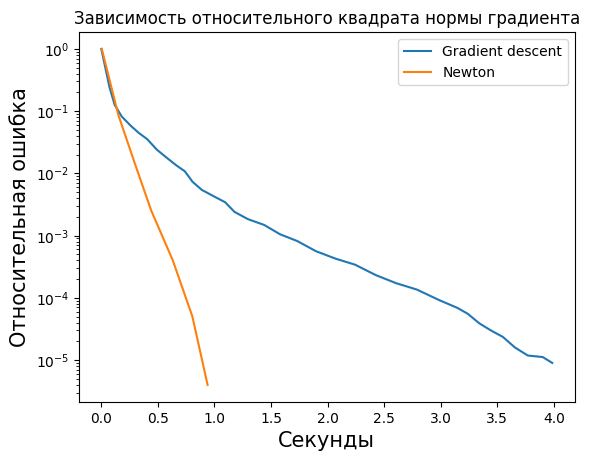

In [300]:
exp_3('w8a.txt')

c:\Users\Алим\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


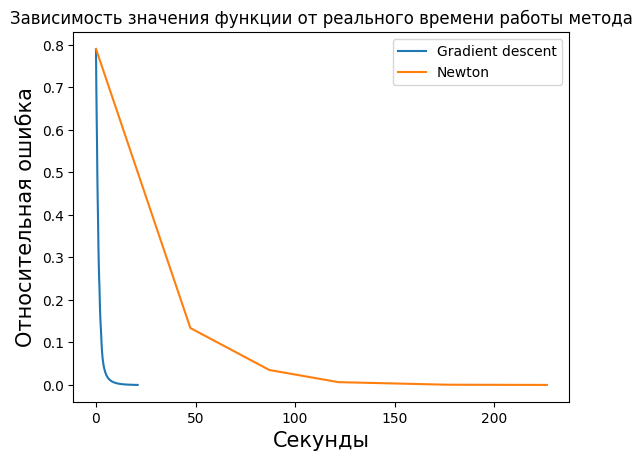

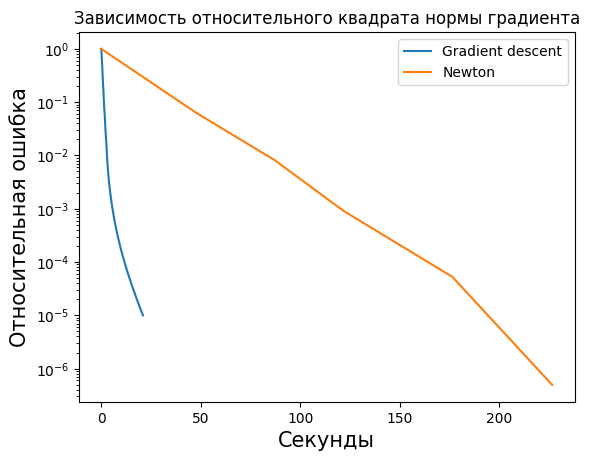

In [16]:
exp_3('real-sim.bz2')

In [251]:
def iteration_per_nevyazka(history, color, label):
    plt.semilogy(np.abs((history['func'] - history['func'][-1]) / history['func'][0]), color=color, label=label)
    plt.xlabel("Итерации", fontsize=12)
    plt.ylabel(r'Относительная ошибка', fontsize=12)


def iteration_per_grad(history, color, label):
    norm = history['grad_norm'][0]
    plt.semilogy(np.array(history['grad_norm']) ** 2 / norm ** 2, color=color, label=label)
    plt.xlabel("Итерации", fontsize=12)
    plt.ylabel(r'Относительная ошибка', fontsize=12)

In [252]:
def func_const(oracle, x0, cs, colors, flag):
    for i, c in enumerate(cs):
        [x_star, _, history] = gradient_descent(oracle, x0, line_search_options={'method': 'Constant', 'c': c},
                                                        trace=True)
        if flag == 0:
            iteration_per_nevyazka(history, colors[i], f"Constant, c={c}")
        else:
            iteration_per_grad(history, colors[i], f"Constant, c={c}")


def func_armijo(oracle, x0, c1s, colors, flag):
    for i, c1 in enumerate(c1s):
        [x_star, _, history] = gradient_descent(oracle, x0, line_search_options={'method': 'Armijo', 'c1': c1, 'alpha_0': 10},
                                                        trace=True)
        if flag == 0:
            iteration_per_nevyazka(history, colors[i], f"Armijo, c1={c1}")
        else:
            iteration_per_grad(history, colors[i], f"Armijo, c1={c1}")


def func_wolfe(oracle, x0, c2s, colors, flag):
    for i, c2 in enumerate(c2s):
        [x_star, _, history] = gradient_descent(oracle, x0, line_search_options={'method': 'Wolfe', 'c2': c2, 'c1' : 0.01, 'alpha_0': 10},
                                                        trace=True)
        if flag == 0:
            iteration_per_nevyazka(history, colors[i], f"Wolfe, c2={c2}")
        else:
            iteration_per_grad(history, colors[i], f"Wolfe, c2={c2}")

In [236]:
def exp4(func, oracle, x):
    if func == "residual_log":
        c = [0.001, 0.01, 0.1]
        colors = ['red', 'blue', 'yellow']
        func_const(oracle, x, c, colors, 0)
        plt.legend()
        plt.show()

        c1 = [0.1, 0.4, 0.8]
        func_armijo(oracle, x, c1, colors, 0)
        plt.legend()
        plt.show()

        c2 = [0.2, 0.4, 0.95]
        func_wolfe(oracle, x, c2, colors, 0)
        plt.legend()
        plt.show()
    elif func == "residual_kvfunc":
        c = [0.001, 0.01, 0.1]
        colors = ['red', 'blue', 'yellow']
        func_const(oracle, x, c, colors, 0)
        plt.legend()
        plt.show()

        c1 = [0.1, 0.4, 0.8]
        func_armijo(oracle, x, c1, colors, 0)
        plt.legend()
        plt.show()

        c2 = [0.1, 0.5, 0.95]
        func_wolfe(oracle, x, c2, colors, 0)
        plt.legend()
        plt.show()
    elif func == "grad_log":
        c = [0.001, 0.01, 0.1]
        colors = ['red', 'blue', 'yellow']
        func_const(oracle, x, c, colors, 1)
        plt.legend()
        plt.show()

        c1 = [0.1, 0.4, 0.8]
        func_armijo(oracle, x, c1, colors, 1)
        plt.legend()
        plt.show()

        c2 = [0.2, 0.4, 0.95]
        func_wolfe(oracle, x, c2, colors, 1)
        plt.legend()
        plt.show()
    elif func == "grad_kvfunc":
        c = [0.001, 0.01, 0.1]
        colors = ['red', 'blue', 'yellow']
        func_const(oracle, x, c, colors, 1)
        plt.legend()
        plt.show()

        c1 = [0.1, 0.4, 0.8]
        func_armijo(oracle, x, c1, colors, 1)
        plt.legend()
        plt.show()

        c2 = [0.2, 0.5, 0.95]
        func_wolfe(oracle, x, c2, colors, 1)
        plt.legend()
        plt.show()
        

In [234]:
def log_matrix(m=100, n=80):
    A = np.random.randn(m, n)
    b = np.sign(np.random.randn(m))
    return A, b

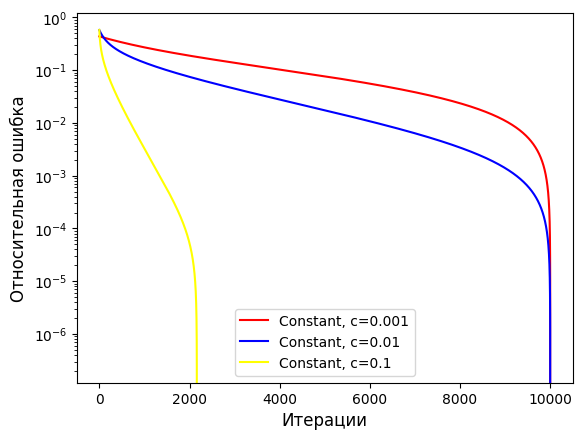

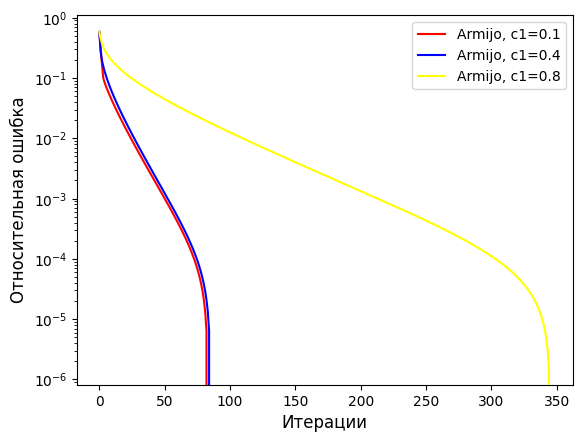

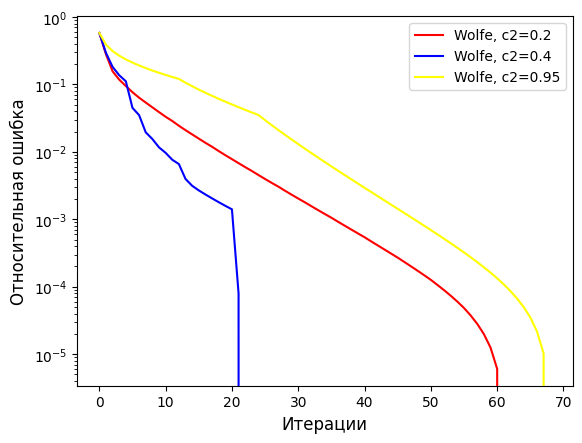

In [240]:
A, b = log_matrix()
m, n = A.shape
oracle_log = create_log_reg_oracle(A, b, 1 / m, oracle_type='usual')
x = np.zeros(n)
exp4('residual_log', oracle_log, x)

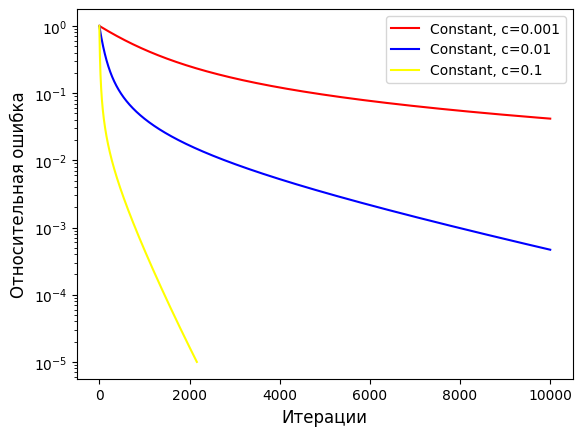

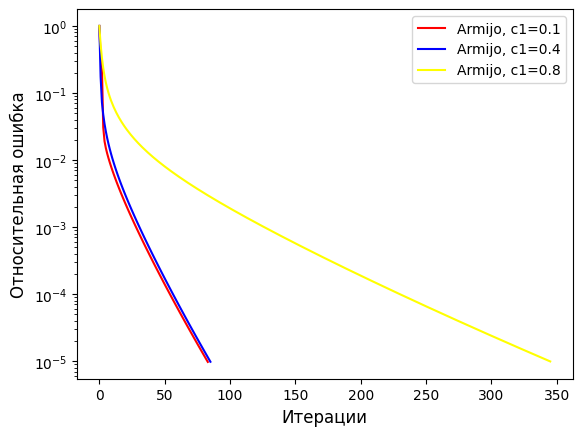

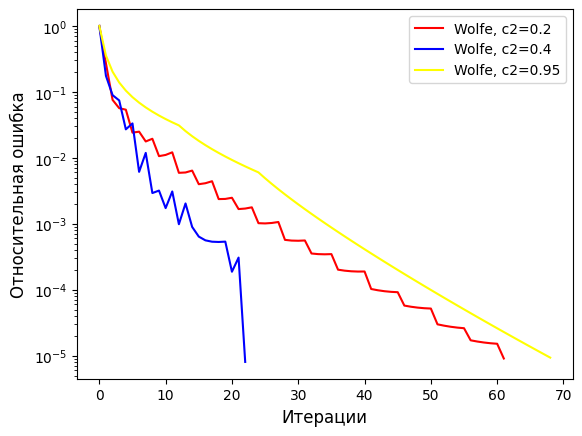

In [241]:
exp4('grad_log', oracle_log, x)

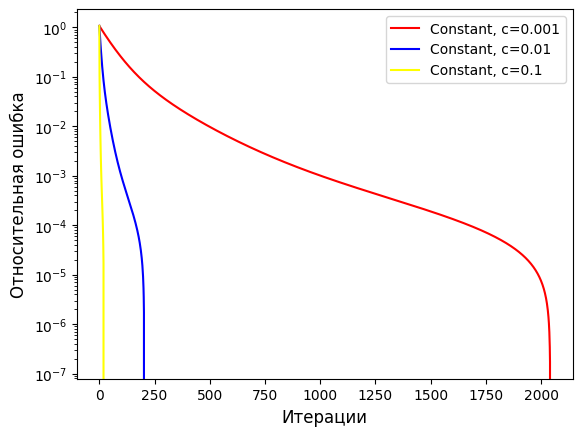

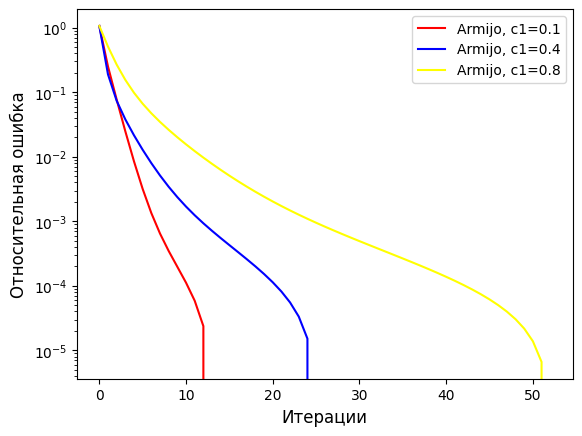

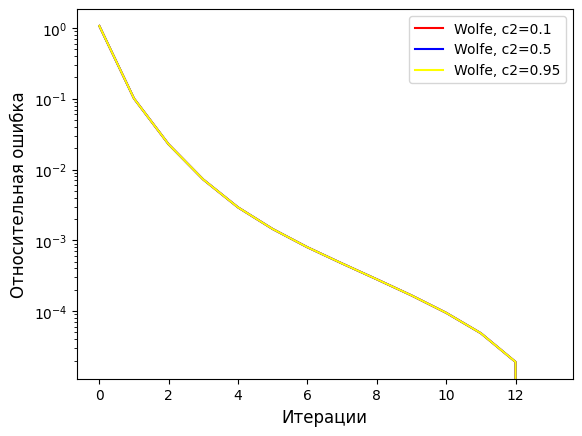

In [230]:
A, b = matrix(10, 10)
x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
oracle_kv = QuadraticOracle(A, b)
exp4('residual_kvfunc', oracle_kv, x)

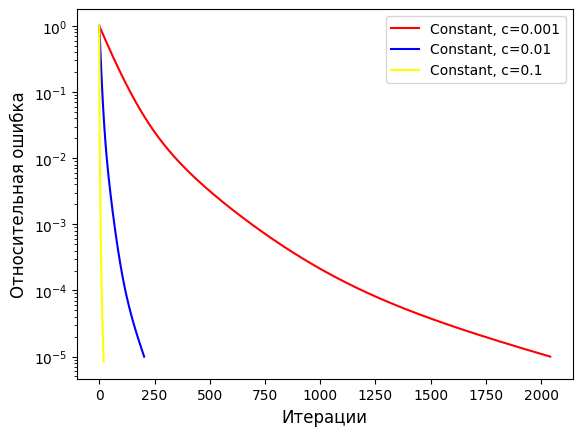

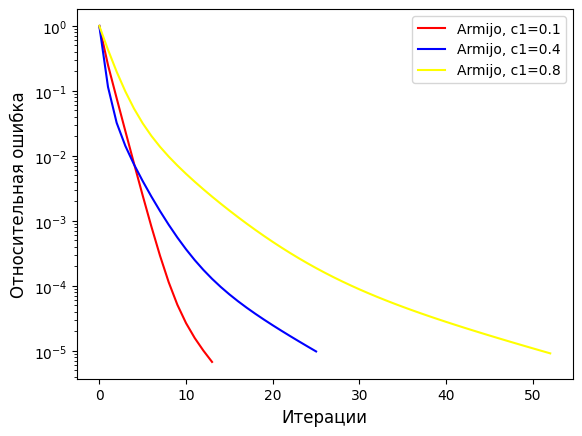

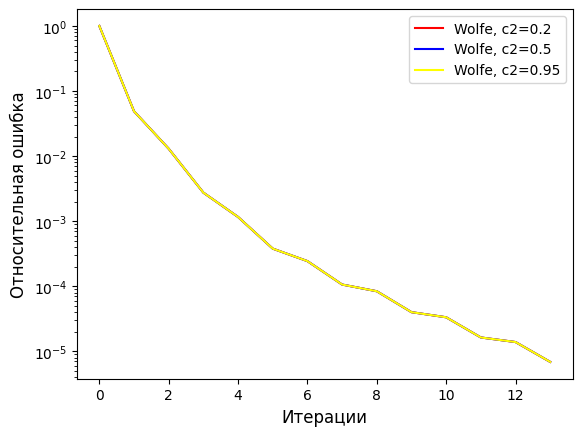

In [231]:
exp4('grad_kvfunc', oracle_kv, x)

In [243]:
def func_const(oracle, x0, cs, colors, flag):
    for i, c in enumerate(cs):
        [x_star, _, history] = newton(oracle, x0, line_search_options={'method': 'Constant', 'c': c},
                                                        trace=True)
        if flag == 0:
            iteration_per_nevyazka(history, colors[i], f"Constant, c={c}")
        else:
            iteration_per_grad(history, colors[i], f"Constant, c={c}")


def func_armijo(oracle, x0, c1s, colors, flag):
    for i, c1 in enumerate(c1s):
        [x_star, _, history] = newton(oracle, x0, line_search_options={'method': 'Armijo', 'c1': c1, 'alpha_0': 10},
                                                        trace=True)
        if flag == 0:
            iteration_per_nevyazka(history, colors[i], f"Armijo, c1={c1}")
        else:
            iteration_per_grad(history, colors[i], f"Armijo, c1={c1}")


def func_wolfe(oracle, x0, c2s, colors, flag):
    for i, c2 in enumerate(c2s):
        [x_star, _, history] = newton(oracle, x0, line_search_options={'method': 'Wolfe', 'c2': c2, 'c1' : 0.001, 'alpha_0': 10},
                                                        trace=True)
        if flag == 0:
            iteration_per_nevyazka(history, colors[i], f"Wolfe, c2={c2}")
        else:
            iteration_per_grad(history, colors[i], f"Wolfe, c2={c2}")

In [244]:
def exp5(func, oracle, x):
    if func == "residual_log":
        с = [0.3, 0.6, 1]
        colors = ['red', 'blue', 'yellow']
        func_const(oracle_log, x, с, colors, 0)
        plt.legend()
        plt.show()

        с1 = [0.2, 0.85, 0.9]
        func_armijo(oracle_log, x, с1, colors, 0)
        plt.legend()
        plt.show()

        с2 = [0.2, 0.25, 0.9]
        func_wolfe(oracle_log, x, с2, colors, 0)
        plt.legend()
        plt.show()
    elif func == "grad_log":
        с = [0.001, 0.01, 0.1]
        colors = ['red', 'blue', 'yellow']
        func_const(oracle_log, x, с, colors, 1)
        plt.legend()
        plt.show()

        с1 = [0.5, 0.75, 0.9]
        func_armijo(oracle_log, x, с1, colors, 1)
        plt.legend()
        plt.show()

        с2 = [0.2, 0.25, 0.95]
        func_wolfe(oracle_log, x, с2, colors, 1)
        plt.legend()
        plt.show()
        

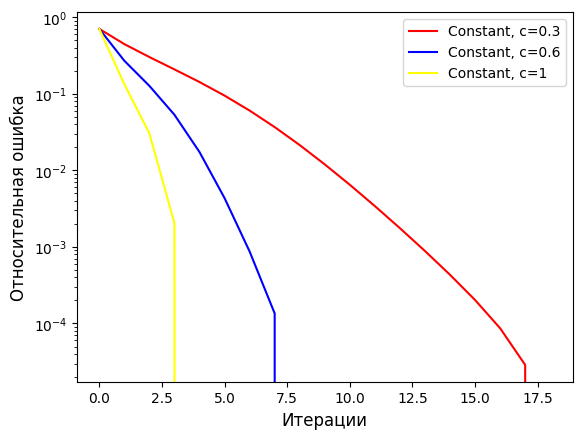

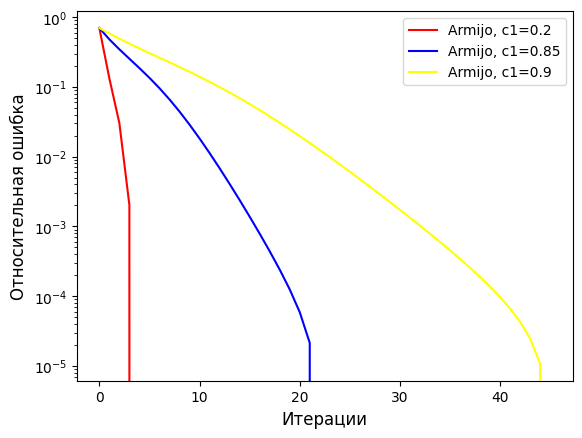

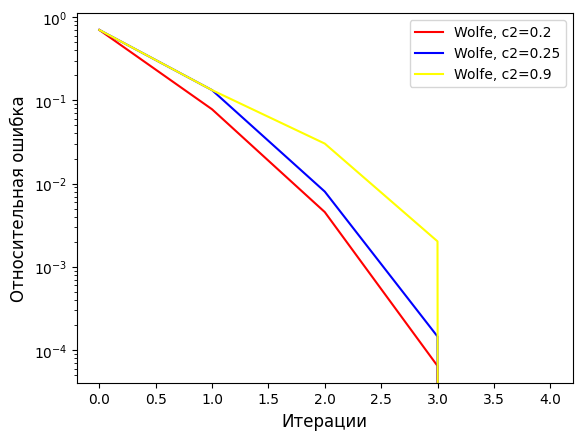

In [245]:
A, b = log_matrix()
m, n = A.shape
oracle_log = create_log_reg_oracle(A, b, 1 / m, oracle_type='usual')
x = np.zeros(n)
exp5('residual_log', oracle_log, x)

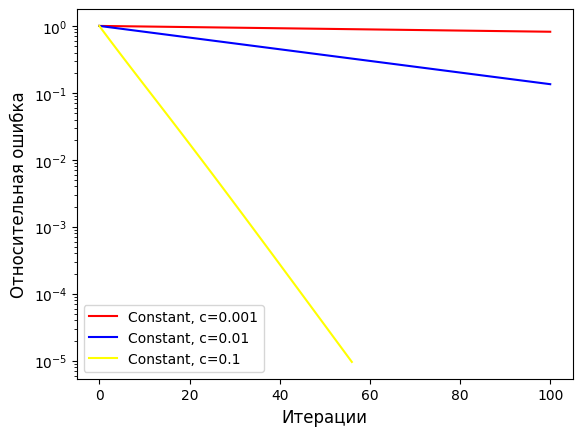

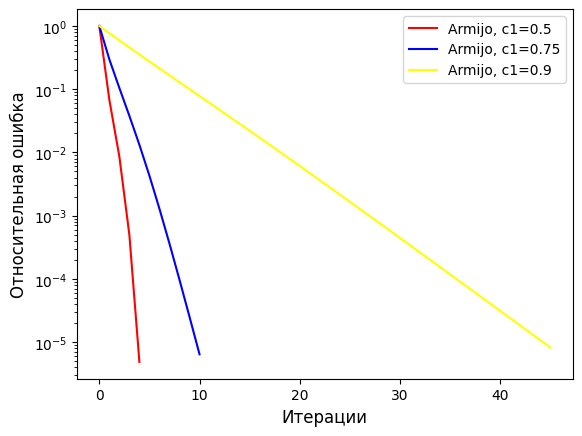

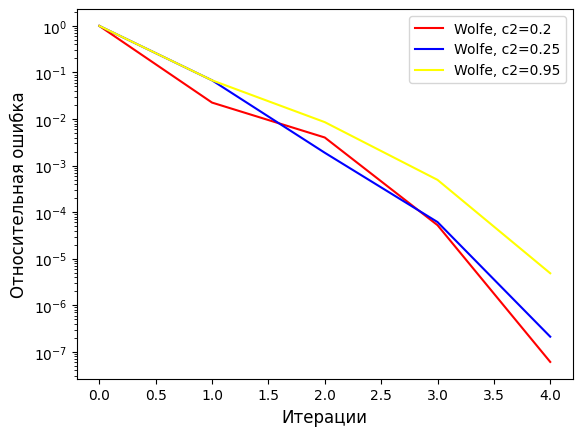

In [247]:
exp5('grad_log', oracle_log, x)